Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


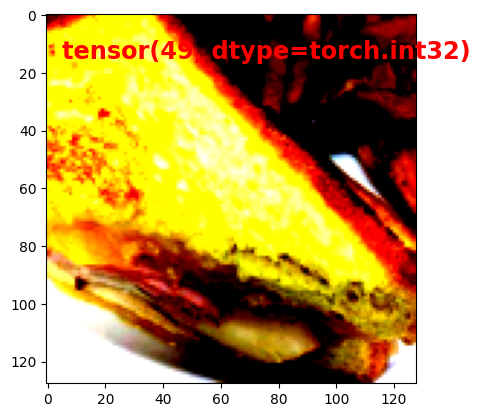

In [31]:
### 1. Data Loaders + Imports ###
import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

train_dataset = torchvision.datasets.Food101("./data", split="train", download=True)
test_dataset = torchvision.datasets.Food101("./data", split="test", download=True)

def collate_fn(examples):

  processed_images = []
  processed_labels = []

  for example in examples:

    image = example[0].resize((128, 128))
    tensor_image = to_tensor(image)
    # normalized_tensor_image = normalize(tensor_image, tensor_image.mean([1,2]), tensor_image.std([1,2]))
    # normalized_tensor_image = normalize(tensor_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    normalized_tensor_image = normalize(tensor_image, [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    vector_image = normalized_tensor_image.unsqueeze(0)
    processed_images.append(vector_image)

    label = np.array(example[1])
    tensor_label = torch.tensor(label)
    tensor_label = tensor_label.unsqueeze(0)
    processed_labels.append(tensor_label)

  torch_images = torch.cat(processed_images, dim=0)
  torch_labels = torch.cat(processed_labels, dim=0)

  return torch_images, torch_labels
  
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


see_examples = 2
for i, (imgs, label) in enumerate(train_loader):
    clear_output(wait=True)
    image = imgs[0].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.text(5, 15, label[0], fontsize ='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)

# for images, labels in train_loader:
#     print(images, labels)
#     break
# print(train_loader.__getitem__(0))
# for index, batch in enumerate(train_loader):
#     print('Dimensiunile primei imagini din primul batch extras: ', batch[0][0].size())
#     break

In [32]:
### 2. Train & Test Accuracy Functions ###

def test_acc(net: nn.Module, test_loader: DataLoader):

  net.to(device)
  net.eval()
  
  total = 0
  correct = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

  losses = []
  accuracies = []

  net.to(device)

  for e in range(epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
      images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_fn(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / train_dataset_length

    print(f"Loss-ul la finalul epocii {e + 1}: {loss.item()}. Average epoch loss: {epoch_loss}")

    acc = test_acc(net, test_loader)
    print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

    losses.append(loss.item())
    accuracies.append(acc)

  loss_graph(losses)
  accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

**Food101 using ResNet50 Pretrained + fine tuning**

In [33]:
epochs = 10
resnet = models.resnet50(pretrained=True)

# Freeze all layers except the final classification layer
for param in resnet.parameters():
    param.requires_grad = False

# Modify the final classification layer
num_classes = len(train_dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, resnet, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')

torch.save(resnet.state_dict(), 'resnet_model_fined_trying.pkl')


Training started
Loss-ul la finalul epocii 1: 5.328947067260742. Average epoch loss: 3.1882860652306686
Acuratetea la finalul epocii 1 este 39.70%
Loss-ul la finalul epocii 2: 1.4122575521469116. Average epoch loss: 2.9031550187875728
Acuratetea la finalul epocii 2 este 40.58%
Loss-ul la finalul epocii 3: 2.460118293762207. Average epoch loss: 2.802817725505766
Acuratetea la finalul epocii 3 este 41.31%
Loss-ul la finalul epocii 4: 1.990027904510498. Average epoch loss: 2.727000601362474
Acuratetea la finalul epocii 4 este 41.03%


KeyboardInterrupt: 